# Multimodal QA with BLIP-2 and Amazon Bedrock

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

### Context
Multimodal question-answering (QA) systems are gaining prominence as they can comprehend both text and visual information. Multimodal content is prevalent in today's digital landscape, often found in documents such as PDFs that combine text and images. Traditional OCR models cannot generate descriptions or context for images. While OCR can recognize and extract text within images, it does not provide meaningful descriptions of the visual elements. This is a critical limitation when attempting to perform QA on images or when seeking to provide image context for users. Moreover, text-to-text models alone would not be sufficient to perform the specific task of extracting image descriptions from PDF documents. A combination of text-to-text models and image-to-text models is essential for processing PDF documents with mixed text and visual content.

### Pattern
The pattern involves combining BLIP-2 and Claude in a multimodal QA system. BLIP-2 excels in image understanding, while Claude is a powerful text-based language model available via Bedrock API. The two models work synergistically to provide comprehensive answers to user queries, which can involve a combination of text and images. The proposed solution is to initiate with a PDF document, utilizing Blip-2 to process the images, generate image descriptions, and comprehend their visual content. Claude processes the textual content within the document. Users can then pose questions related to both the textual and visual aspects of the content. The system analyzes these queries, utilizes BLIP-2 for image description and Claude for text understanding, thereby facilitating comprehensive and intuitive question-answering. This approach enhances content extraction and QA on multimodal documents, making it valuable in fields like education, research, content curation, and more.


### Challenges

- Integrating BLIP-2 and Claude to handle both text and images in PDF documents.
- Maintaining context between textual and visual elements to ensure meaningful answers in multimodal QA.

### Proposal
To the above challenges, this notebook proposes the following strategy

![Diagram](./images/diagram.png)

#### Deploy BLIP-2 to a SageMaker endpoint
You can host an LLM on SageMaker using the Large Model Inference (LMI) container that is optimized for hosting large models using DJLServing. 

- Retrieve the Docker image of DJLServing
- Package the inference script and configuration files as a model.tar.gz file
- Upload the model.tar.gz file to Amazon S3 bucket
- Create the model, the configuration for the endpoint, and the endpoint

More details can be found in this blog: https://aws.amazon.com/it/blogs/machine-learning/build-a-generative-ai-based-content-moderation-solution-on-amazon-sagemaker-jumpstart/

#### Load, split, and invoke the endpoint
When the endpoint is deployed, you are ready to extract the text and image from a PDF, and invoke the endpoint to generate the image description and comprehend its visual content.

- Load a pdf from local disk
- Extract text and image
- Invoke the BLIP-2 endpoint

#### Invoke the Bedrock API for QA
After extracting image description, you can invoke the Bedrock API with a predifined prompt template to produce organized QA responses based on user queries and the extracted content.

- Create prompt templates
- Invoke the Bedrock API 




In [2]:
!pip install sagemaker boto3 huggingface_hub --upgrade --quiet


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import sagemaker
import boto3
import os
import time
import json
import base64
from pathlib import Path
from sagemaker import image_uris

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
model_bucket = sess.default_bucket()  # bucket to house artifacts
s3_code_prefix = "blip2"  # folder within bucket where code artifact will go
s3_model_prefix = "model_blip2"  # folder within bucket where code artifact will go
region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

# Define a variable to contain the s3url of the location that has the model
pretrained_model_location = f"s3://{model_bucket}/{s3_model_prefix}/"
print(f"Pretrained model will be uploaded to ---- > {pretrained_model_location}")

Pretrained model will be uploaded to ---- > s3://sagemaker-us-east-1-144423338924/model_blip2/


## Prepare inference script and container image

In [6]:
from sagemaker.huggingface import HuggingFaceModel

try:
	role = sagemaker.get_execution_role()
except ValueError:
	iam = boto3.client('iam')
	role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

# Hub Model configuration. https://huggingface.co/models
hub = {
	'HF_MODEL_ID':'Salesforce/blip2-flan-t5-xxl',
	'HF_TASK':'image-to-text'
}

# Create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
	transformers_version='4.26.0',
	pytorch_version='1.13.1',
	py_version='py39',
	env=hub,
	role=role, 
)

# Deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
	initial_instance_count=1, # number of instances
	instance_type='ml.m5.xlarge' # ec2 instance type
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
----!

In [7]:
inference_image_uri = image_uris.retrieve(
    framework="djl-deepspeed", region=sess.boto_session.region_name, version="0.22.1"
)
inference_image_uri

'763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.22.1-deepspeed0.9.2-cu118'

In [8]:
blip_model_version = "blip2-flan-t5-xl"
model_names = {
    "caption_model_name": blip_model_version, #@param ["blip-base", "blip-large", "blip2-flan-t5-xl"]
}
with open("blip2/model_name.json",'w') as file:
    json.dump(model_names, file)

In this notebook, we will provide two ways to load the model when deploying to an endpoint.
- Directly load from Hugging Face 
- Store the model artifacts on S3 and load the model directly from S3

The [Large Model Inference (LMI)](https://docs.aws.amazon.com/sagemaker/latest/dg/large-model-inference-dlc.html) container uses [s5cmd](https://github.com/peak/s5cmd) to download data from S3 which significantly reduces the speed when loading model during deployment.

If you choose to load the model directly from Hugging Face during model deployment, you can skip the below section and jump to the section to **Prepare BLIP-2 model tarball file and upload to S3**.

### Download the model from Hugging Face and upload the model artifacts on Amazon S3

In [9]:
from huggingface_hub import snapshot_download
from pathlib import Path

CAPTION_MODELS = {
    'blip-base': 'Salesforce/blip-image-captioning-base',   # 990MB
    'blip-large': 'Salesforce/blip-image-captioning-large', # 1.9GB
    'blip2-2.7b': 'Salesforce/blip2-opt-2.7b',              # 15.5GB
    'blip2-flan-t5-xl': 'Salesforce/blip2-flan-t5-xl',      # 15.77GB
}

# This will download the model into the current directory where ever the jupyter notebook is running
local_model_path = Path("./blip2-model")
local_model_path.mkdir(exist_ok=True)
model_name = CAPTION_MODELS[blip_model_version]

# Only download pytorch checkpoint files
allow_patterns = ["*.json", "*.pt", "*.bin", "*.txt", "*.model"]

# Leverage the snapshot library to donload the model since the model is stored in repository using LFS
model_download_path = snapshot_download(
    repo_id=model_name,
    cache_dir=local_model_path,
    allow_patterns=allow_patterns,
)

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

(…)a443a226614/pytorch_model.bin.index.json:   0%|          | 0.00/128k [00:00<?, ?B/s]

(…)d4d1c37753c7e9c05a443a226614/config.json:   0%|          | 0.00/7.68k [00:00<?, ?B/s]

(…)1c37753c7e9c05a443a226614/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

(…)e9c05a443a226614/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

(…)9c05a443a226614/preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/6.33G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.44G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

(…)c7e9c05a443a226614/tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Please make sure the file is downloaded correctly by checking the files exist in the newly created folder `blip2-model/models--Salesforce--<model-name>/snapshots/...` before running the below cell.

In [10]:
# Upload the model artifacts to s3
model_artifact = sess.upload_data(path=model_download_path, key_prefix=s3_model_prefix)
print(f"Model uploaded to --- > {model_artifact}")
print(f"We will set option.s3url={model_artifact}")

Model uploaded to --- > s3://sagemaker-us-east-1-144423338924/model_blip2
We will set option.s3url=s3://sagemaker-us-east-1-144423338924/model_blip2


In [11]:
!rm -rf {local_model_path}

In [12]:
%%writefile blip2/serving.properties
engine = Python
option.tensor_parallel_degree = 1
option.model_id = {{s3url}}

Overwriting blip2/serving.properties


In [14]:
# Plug in the appropriate model location into our `serving.properties` file based on the region in which this notebook is running
import jinja2

jinja_env = jinja2.Environment()
template = jinja_env.from_string(Path("blip2/serving.properties").open().read())
Path("blip2/serving.properties").open("w").write(
    template.render(s3url=pretrained_model_location)
)
!pygmentize blip2/serving.properties | cat -n

     1	engine = Python
     2	option.tensor_parallel_degree = 1
     3	option.model_id = s3://sagemaker-us-east-1-144423338924/model_blip2/


## Prepare BLIP-2 model tarball file and upload to S3

In [15]:
%%sh
tar czvf model.tar.gz blip2/

blip2/
blip2/model.py
blip2/requirements.txt
blip2/model_name.json
blip2/serving.properties


In [16]:
s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-east-1-144423338924/blip2/model.tar.gz


## Deploy BLIP-2 model

In [17]:
from sagemaker.model import Model
from sagemaker.utils import name_from_base

model_name = name_from_base(blip_model_version)
model = Model(
    image_uri=inference_image_uri,
    model_data=s3_code_artifact,
    role=role,
    name=model_name,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [19]:
%%time
endpoint_name = "endpoint-" + model_name
model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.2xlarge",
    endpoint_name=endpoint_name
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
--------------!CPU times: user 136 ms, sys: 9.25 ms, total: 145 ms
Wall time: 7min 33s


In [20]:
%store endpoint_name

Stored 'endpoint_name' (str)


## Test Inference Endpoint

In [21]:
from PIL import Image
import base64

smr_client = boto3.client("sagemaker-runtime")
endpoint_name = model.endpoint_name

In [22]:
# Encode the image in base64
def encode_image(img_file):
    with open(img_file, "rb") as image_file:
        img_str = base64.b64encode(image_file.read())
        base64_string = img_str.decode("latin1")
    return base64_string

# Run inference on the endpoint
def run_inference(endpoint_name, inputs):
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name, Body=json.dumps(inputs)
    )
    return response["Body"].read().decode('utf-8')

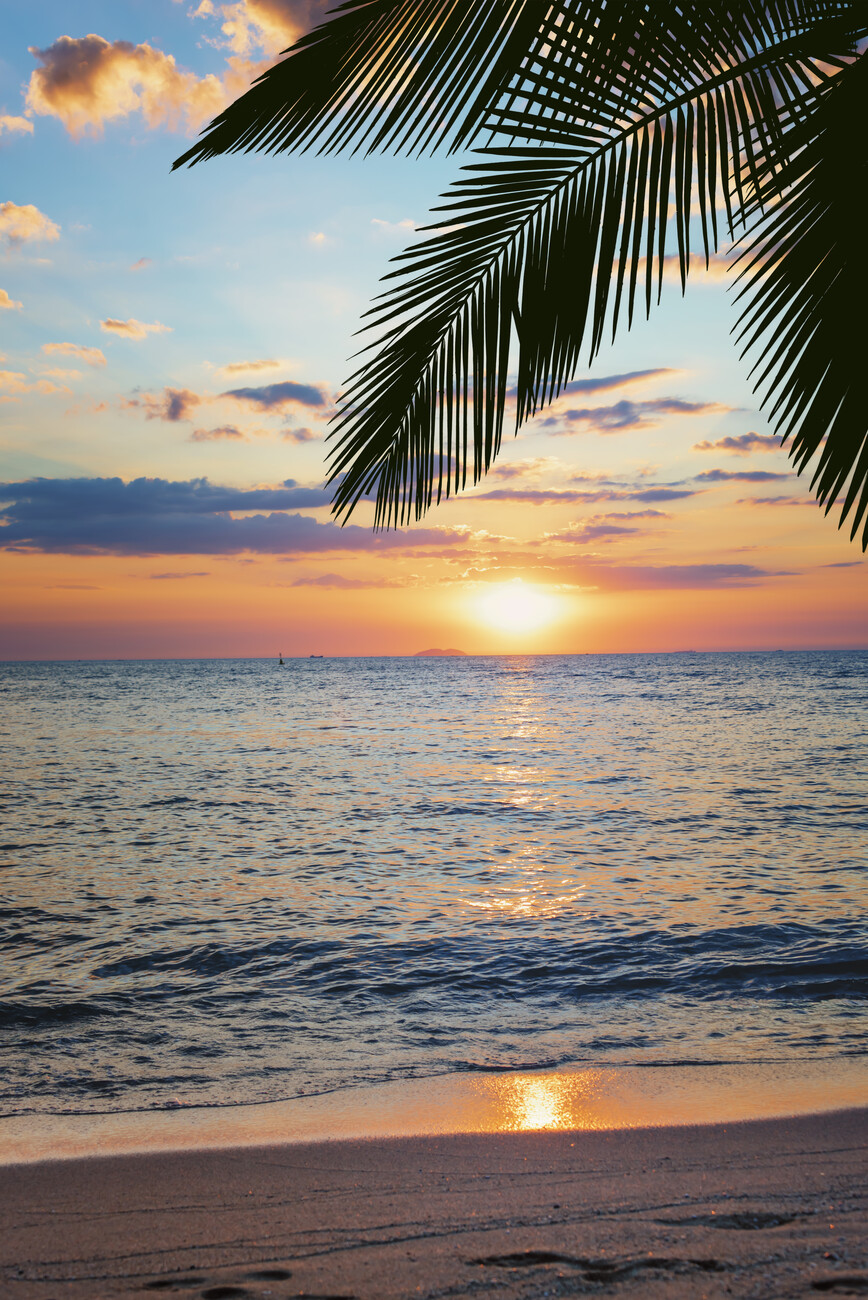

In [23]:
# Display a test image
test_image = "test_image.jpg"
raw_image = Image.open(test_image).convert('RGB')
display(raw_image)

In [24]:
# Encode the test image and send it to the endpoint.
base64_string = encode_image(test_image)
inputs = {"image": base64_string}
run_inference(endpoint_name, inputs)

'a palm tree on a beach'

## Load pdf, split image and text, run inference on the image

In [25]:
import fitz
%pip install PyMuPDF


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
# Function that extracts text and images from PDF
def extract_text_and_images_from_pdf(filename):
    try:
        # Open the PDF file
        pdf_document = fitz.open(filename)

        # Initialize the text variable
        text = ''

        # Extract text
        for page in pdf_document:
            text += page.get_text()

        # Print the extracted text
        print("Extracted Text:")
        print(text)

        # Initialize the image_filename variable
        image_filename = ''

        # Extract images
        for page_number, page in enumerate(pdf_document, start=1):
            images = page.get_images(full=True)
            for index, image in enumerate(images):
                xref = image[0]
                base_image = pdf_document.extract_image(xref)
                image_data = base_image["image"]

                # Assign a new value to image_filename within the loop
                image_filename = f'{filename}.png'
                with open(image_filename, "wb") as image_file:
                    image_file.write(image_data)

        # Print the image filename
        print("Image Filename:", image_filename)

        # Close the PDF document
        pdf_document.close()

        return text, image_filename

    except Exception as e:
        print("An error occurred:", str(e))
        return None, None

In [27]:
# Get text and save the image on the local disk from a PDF
filename='Tropical_Paradise.pdf'
text, image_filename=extract_text_and_images_from_pdf(filename)

Extracted Text:
 
**Tropical Paradise: Discover the Magic of Palm-Fringed Beaches!** 
 
 
 
Are you yearning for an escape from the mundane, a journey to a realm of natural beauty 
and serene bliss? Look no further than Tropical Paradise, where your ideal seaside getaway 
becomes a reality. 
 
**A Dreamlike DesHnaHon:** 
Picture waking up to the melodious symphony of waves gently caressing the shore, your 
gaze met by an endless expanse of golden sands adorned with majesHc palm trees swaying 
gracefully to the rhythm of the ocean breeze. This is the embodiment of your dream 
desHnaHon, where reality eﬀortlessly outshines the most vivid of fantasies. 
 
**Untouched, PrisHne Beaches:** 
Our untouched, prisHne beaches beckon you to embark on romanHc sunset strolls, build 
intricate sandcastles with the liNle ones, or simply bask in the lap of luxury on our plush 
loungers while the sun warmly envelops you. The crystal-clear waters are an open invitaHon 
to swim, snorkel, or merely savor t

In [28]:
# Send the image to the endpoint
base64_string = encode_image(image_filename)
inputs = {"image": base64_string}
image_description = run_inference(endpoint_name, inputs)
image_description

'a palm tree on a beach'

## Bedrock API for QA

In [29]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"

  Obtaining dependency information for boto3>=1.28.57 from https://files.pythonhosted.org/packages/50/58/2324b65441c0f83013d27ad8e4b614688d4dd79237ff43d1488dfcc01f3b/boto3-1.28.64-py3-none-any.whl.metadata
  Using cached boto3-1.28.64-py3-none-any.whl.metadata (6.7 kB)
  Obtaining dependency information for awscli>=1.29.57 from https://files.pythonhosted.org/packages/92/7c/e758cf82d1dbf5ad13fac296bc43ce4f099ff62000ce0f47321cd160ce52/awscli-1.29.64-py3-none-any.whl.metadata
  Using cached awscli-1.29.64-py3-none-any.whl.metadata (11 kB)
  Obtaining dependency information for botocore>=1.31.57 from https://files.pythonhosted.org/packages/d0/68/6a9c405bc6c6e7d832743a458c87f21cee393ef2cf32437a0a3a07cd0ae9/botocore-1.31.64-py3-none-any.whl.metadata
  Using cached botocore-1.31.64-py3-none-any.whl.metadata (6.1 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
  Obtaining dependency information for s3transfer<0.8.0,>=0.7.0 from https://files.pythonhosted.org/packages/5a/4b/fec9ce18f

In [30]:
import json
import sys

import botocore

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww


# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

# os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
# os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
# os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."


bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None)
)

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


In [31]:
# Create a prompt tenplate for summarization
prompt_data = f"""
Human: I am proving you an image description and a text. 

<image description>
{image_description}
<\image description>

<text>
{text}
<\text>

Please provide a summary of the image description and text.

Assistant:
"""

In [32]:
# Invoke the Bedrock API using the prompt template 
body = json.dumps({"prompt": prompt_data, "max_tokens_to_sample": 500})
modelId = "anthropic.claude-instant-v1"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

try:
    
    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body.get("completion"))

except botocore.exceptions.ClientError as error:
    
    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")
        
    else:
        raise error

 Here is a summary of the image description and text:

The image description shows a palm tree on a beach. 

The text is an advertisement promoting a tropical beach resort called Tropical Paradise. It describes the resort's palm-fringed beaches with golden sand and crystal clear waters. It highlights activities available like water sports, jungle treks and relaxing massages. It promotes the resort as an escape from everyday life where one can unwind beneath palm trees while enjoying coconut drinks and gourmet cuisine. It encourages the reader to book a stay at Tropical Paradise to experience a slice of paradise and make unforgettable memories.

In summary, the image and text are promoting an idyllic tropical beach resort with palm trees, sandy beaches and ocean activities for relaxation and adventure.


In [33]:
# Load a more complex pdf, split image and text, run inference on the image
filename='WEF_Better_Climate_Better_Health_September_2023-23.pdf'
text, image_filename=extract_text_and_images_from_pdf(filename)
base64_string = encode_image(image_filename)
inputs = {"image": base64_string}
image_description = run_inference(endpoint_name, inputs)

Extracted Text:
Climate (and climate health) 
governance in China
China’s climate governance has always operated 
within a hierarchical system in line with the 
characteristics of the Chinese political system, 
namely “top-level design – national strategy –
sectoral and local action”.123 The establishment 
of the National Climate Change Response 
Coordination Group (NCCRCG) in 1998 marked 
the growing importance of climate change in the 
government’s policy agenda since the country’s 
economic reforms began in the 1980s. In 2007, 
China’s National Climate Change Programme124 
was published, further elevating climate change 
to the responsibility of the highest level of the 
government, the State Council, and making it a 
key milestone in the evolution of China’s climate 
governance. In the same year, the National Leading 
Group on Climate Change Response, Energy 
Conservation and Emissions Reduction (NLGCCR) 
was established to improve cross-ministerial 
coordination in climate policy-

In [34]:
# Create a prompt tenplate for QA
prompt_data = f"""
Human: I am proving you an image description and a text. 

<image description>
{image_description}
<\image description>

<text>
{text}
<\text>

Can you give me information about the climate governance of the country in the image?

Assistant:
"""

In [35]:
# Invoke the Bedrock API for QA using the prompt template
body = json.dumps({"prompt": prompt_data, "max_tokens_to_sample": 500})
modelId = "anthropic.claude-instant-v1"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

try:
    
    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body.get("completion"))

except botocore.exceptions.ClientError as error:
    
    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")
        
    else:
        raise error

 Based on the image description and text provided, here is the information about the climate governance of the country in the image:

- The image description mentions "a city in China", so the country is China. 

- The text talks about China's climate governance and how it has operated within a hierarchical system in line with the Chinese political system. 

- It mentions the establishment of the National Climate Change Response Coordination Group (NCCRCG) in 1998, which marked the growing importance of climate change in the government's policy agenda. 

- In 2007, China's National Climate Change Programme was published, further elevating climate change to the responsibility of the highest level of the government, the State Council. 

- Also in 2007, the National Leading Group on Climate Change Response, Energy Conservation and Emissions Reduction (NLGCCR) was established to improve cross-ministerial coordination in climate policy-making. This group is led by the premier and includes m

## Clean up
Uncomment the below cell to delete the endpoint and model when you finish the experiment

In [ ]:
# sm_client.delete_model(ModelName=model_name)
# sm_client.delete_endpoint(EndpointName=endpoint_name)